In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from scipy.stats import spearmanr
import torch.nn.functional as F
import torch
import os

# Load relevant variables and functions

In [ ]:
ref_seq = {'r1': 'MAGSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQTEGSGGSPLAQQIQYGHVLIHQARAAGRMDEVRRLSENTLQLMKEYFQQSD',
           'r2': 'MAGSGSPLAKQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQTEGSGGSPLAQQIQNGHVLIHQARAAGRMDEVRRLSEKTLQLMKEYFQQSD',
           'r3': 'MAGSDSPLAEQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFRQTEGSGGSPLAQQIQNGHVLIHQARAAGRMDEVRRLSEKTLQLMKEYFQQSD'}
CHARS = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L",
         "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
C2I_MAPPING = {c: i for i, c in enumerate(CHARS)}

# given two lists of mutations (relative to WT), find mutational distance in between
def cal_dist_mut(mut1, mut2):
    non_overlap_pos = set()
    print(mut1)
    print(mut2)
    for mut in mut1:
        if mut not in mut2:
            non_overlap_pos.add(int(mut[1:-1]))
    for mut in mut2:
        if mut not in mut1:
            non_overlap_pos.add(int(mut[1:-1]))
    return len(non_overlap_pos)

# given two seqeuneces, find mutational distance in between and return indexes where a mutation occurs
def cal_dist_seq(seq1, seq2):
    dist = 0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i]:
            dist += 1
    return dist


def compute_log_conditional_probs(seq, tokenizer, model):
    """
    Given a single sequence, compute the log-probability
    of its true amino acid at each position i, conditioned
    on masking that position.
    Returns:
        logps: np.array of shape (L,) where L = len(seq)
    """
    L = len(seq)
    logps = np.zeros(L, dtype=np.float32)
    # add BOS/EOS tokens automatically
    for i in range(L):
        masked = list(seq)
        masked[i] = tokenizer.mask_token
        toks = tokenizer("".join(masked),
                         return_tensors="pt",
                         add_special_tokens=True,
                         truncation=True).to(device)
        with torch.no_grad():
            out = model(**toks).logits  # shape (1, T, V)
            # token index = i+1 (after BOS)
            token_idx = i + 1
            # get log‐softmax over vocab at that position
            log_probs = F.log_softmax(out[0, token_idx], dim=-1)
            true_id = tokenizer.convert_tokens_to_ids(seq[i])
            logps[i] = log_probs[true_id].item()
    return logps

# First, specify the round of experiment

In [ ]:
round = 'r2'

# Further filter variants based on sequence length and std

In [ ]:
ref_seq_len = 100
IQR_coefficient = 1.0


input_file = f'/content/drive/MyDrive/Mid_1_data/Variant_data_3_rounds_Mid1_{round}.csv'
df = pd.read_csv(input_file)
# filter based on aa sequence length to prevent early stop
df = df[df['seq'].str.len() == ref_seq_len].reset_index(drop=True)
print(f'Total number of variants with WT len: {len(df)}')


# plot the avg fitness & std distributions to remove any outliers
plt.hist(df['fitness_average'], bins = 30)
plt.xlabel('Fitness average')
plt.ylabel('Frequency')
plt.savefig(f'/content/drive/MyDrive/Mid_1_data/hist_fitness_avg_{round}.png')
plt.close()

plt.hist(df['fitness_std'], bins = 30)
plt.xlabel('Fitness std')
plt.ylabel('Frequency')
plt.savefig(f'/content/drive/MyDrive/Mid_1_data/hist_fitness_std_{round}.png')
plt.close()

# remove noisy data based on IQR for fitness_std (remove Q3 + IQR_coefficient * IQR)
Q1, Q3 = np.quantile(df['fitness_std'], [0.25,0.75])
std_cutoff = Q3 + IQR_coefficient * (Q3-Q1)
df = df[df['fitness_std'] < std_cutoff].reset_index(drop=True)
df.to_csv(f'/content/drive/MyDrive/Mid_1_data/Variant_data_3_rounds_Mid1_filtered_{round}.csv')
print(f'Total number of variants with acceptable fitness std: {len(df)}')

# save seq to index (as in the first dimension of embeddings) mapping
seq_list = [seq.rstrip('*') for seq in list(df['seq'])]
N = len(seq_list)
seq2idx = dict(zip(seq_list, [i for i in range(N)]))
pickle.dump(seq2idx, open(f'/content/drive/MyDrive/Mid_1_data_train/seq_to_index_{round}.pkl', 'wb'))

Total number of variants with WT len: 3255
Total number of variants with acceptable fitness std: 3094


# Generate ESM embeddings

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model     = AutoModel.from_pretrained(model_name).to(device)
model.eval()

lengths = [len(s) for s in seq_list]
L_max = max(lengths)
hidden_dim = model.config.hidden_size

ESM_emb = np.zeros((N, L_max+2, hidden_dim), dtype=np.float32)
batch_size = 16
with torch.no_grad():
    for start in tqdm(range(0, N, batch_size)):
        batch_seqs = seq_list[start:start+batch_size]
        # Tokenize with padding up to the longest seq
        toks = tokenizer(
            batch_seqs,
            return_tensors="pt",
            padding="max_length",
            max_length=L_max+2,
            add_special_tokens=True,
            truncation=True
        )
        input_ids = toks["input_ids"].to(device)
        attention_mask = toks["attention_mask"].to(device)
        out = model(input_ids=input_ids, attention_mask=attention_mask)
        # last_hidden_state: (B, T, hidden_dim)
        last_hidden = out.last_hidden_state

        # For each sequence in batch, extract the residue embeddings
        # HuggingFace ESM2 prepends a BOS token and appends EOS token by default,
        # so token positions 1 .. (seq_len) correspond to protein residues.
        for i, seq in enumerate(batch_seqs):
            seq_len = len(seq)
            emb_residues = last_hidden[i, : seq_len + 2, :].cpu().numpy()
            ESM_emb[start + i, : seq_len + 2, :] = emb_residues

N, L_max, hidden_dim = ESM_emb.shape
# Flatten to (N * L_max, hidden_dim)
flat = ESM_emb.reshape(-1, hidden_dim)
scaler = MinMaxScaler(feature_range=(0,1))
flat_scaled = scaler.fit_transform(flat)
ESM_emb = flat_scaled.reshape(N, L_max, hidden_dim)
print(f'total ESM2 embedding shape: {ESM_emb.shape}')
np.save(f'/content/drive/MyDrive/Mid_1_data_train/ESM_emb_{round}.npy', ESM_emb)


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 194/194 [04:56<00:00,  1.53s/it]


total ESM2 embedding shape: (3094, 101, 1280)


# Generate AAindex embedding

In [ ]:
aaindex_ref = np.load(f'/content/drive/MyDrive/Mid_1_data/aaindex-pca-19.npy')
scaler = StandardScaler()
aaindex_ref = scaler.fit_transform(aaindex_ref)
int_seqs = []
for i in tqdm(range(len(df))):
    seq = df.loc[i, 'seq']
    int_seq = [C2I_MAPPING[seq[j]] for j in range(len(seq)-1)]
    int_seqs.append(int_seq)
int_seqs = np.array(int_seqs)
# shape: N * L * 19
aaindex_emb = aaindex_ref[int_seqs]
# shape: N * (L*19)
aaindex_rr = aaindex_emb.reshape(aaindex_emb.shape[0], -1)
print(f'total AAindex embedding shape: {aaindex_rr.shape}')
np.save(f'/content/drive/MyDrive/Mid_1_data_train/AAindex_emb_{round}.npy', aaindex_rr)

100%|██████████| 3094/3094 [00:00<00:00, 114312.19it/s]

total AAindex embedding shape: (3094, 1881)


# Generate PLL

In [ ]:
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model     = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
model.eval()

# Compute conditional log likelihoods for reference sequence
P_wt = compute_log_conditional_probs(ref_seq[round], tokenizer, model)

# For each sequence, compute PLL
PLL = np.zeros((N, 1), dtype=np.float32)

for idx, seq in tqdm(enumerate(seq_list)):
    # find mutated positions
    muts = [i for i, (a, b) in enumerate(zip(seq, ref_seq[round])) if a != b]
    if not muts:
        PLL[idx, 0] = 0.0
        continue
    # compute log‐probs for each mutated position
    logp_mut = 0.0
    for i in muts:
        masked = list(seq)
        masked[i] = tokenizer.mask_token
        toks = tokenizer("".join(masked),
                        return_tensors="pt",
                        add_special_tokens=True,
                        truncation=True).to(device)
        with torch.no_grad():
            out = model(**toks).logits
            log_probs = F.log_softmax(out[0, i+1], dim=-1)
            true_id = tokenizer.convert_tokens_to_ids(seq[i])
            logp_mut += log_probs[true_id].item()
    # PLL = sum logp_mutated – sum P_wt at those positions
    PLL[idx, 0] = logp_mut - P_wt[muts].sum()

print(f'total PLL shape: {PLL.shape}')
np.save(f'/content/drive/MyDrive/Mid_1_data_train/PLL_{round}.npy', PLL)

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
746it [11:17,  1.10it/s]


total PLL shape: (746, 1)


# Plot the correlation between PLL and fitness

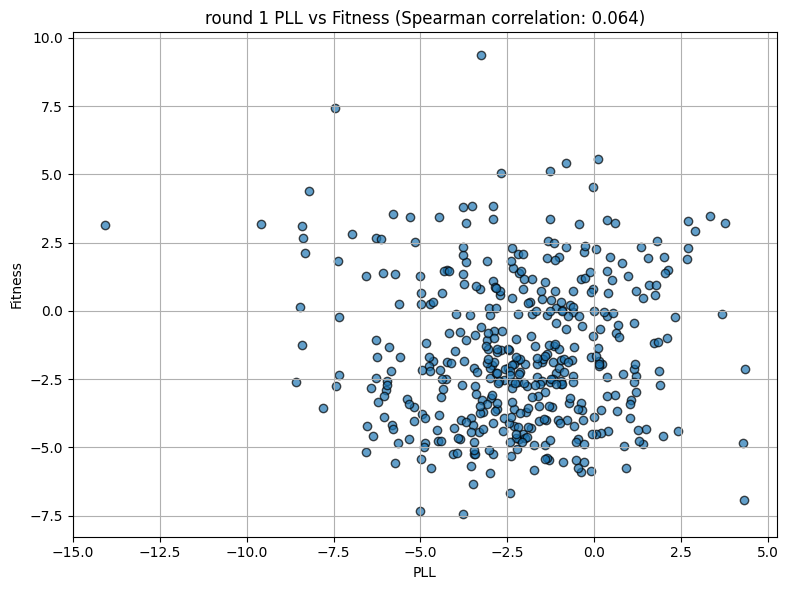

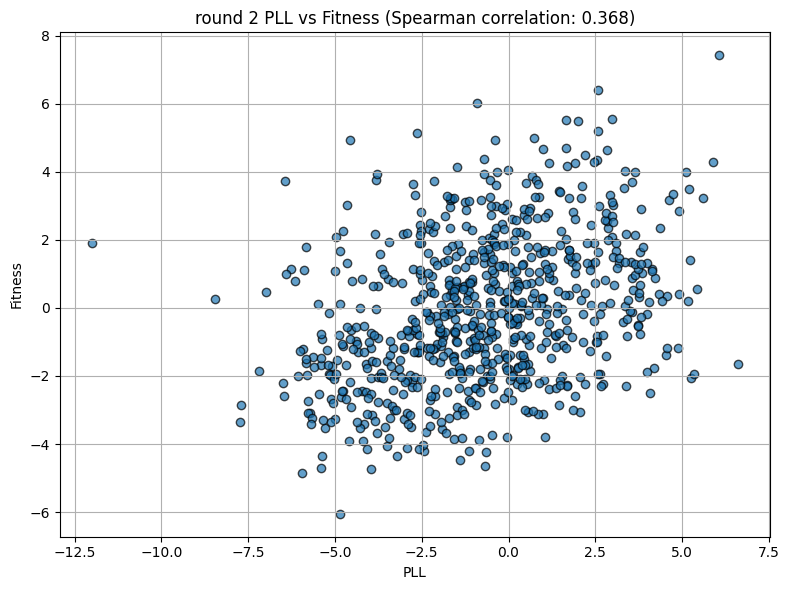

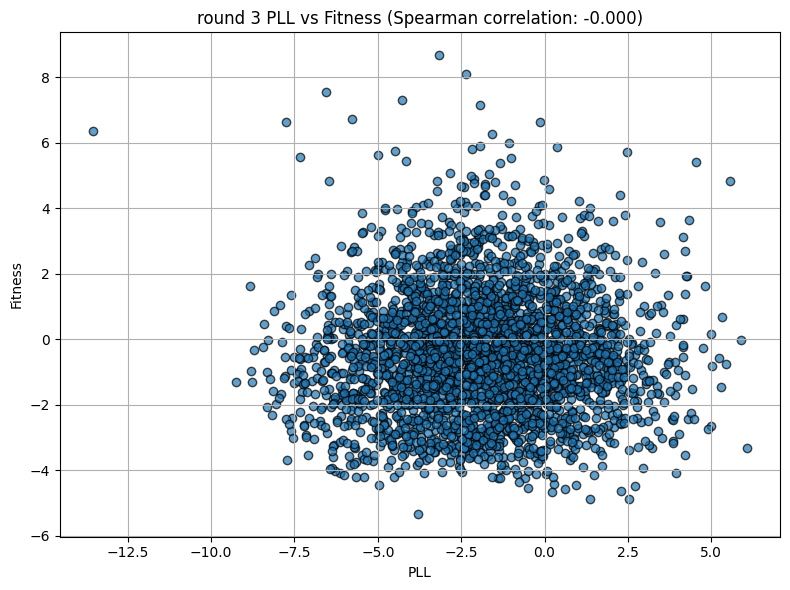

In [ ]:
n_round = 3
for i in range(n_round):
  round = 'r' + str(i+1)
  pll = np.load(f'/content/drive/MyDrive/Mid_1_data_train/PLL_{round}.npy')
  df = pd.read_csv(f'/content/drive/MyDrive/Mid_1_data/Variant_data_3_rounds_Mid1_filtered_{round}.csv')
  corr, _ = spearmanr(pll, df['fitness_average'])

  plt.figure(figsize=(8, 6))
  plt.scatter(pll, df['fitness_average'], alpha=0.7, edgecolors='k')
  plt.title(f'round {round[1:]} PLL vs Fitness (Spearman correlation: {corr:.3f})')
  plt.xlabel('PLL')
  plt.ylabel('Fitness')
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# Generate contrastive learning train/test/inference sets

In [ ]:
# first split train/test samples based on single sequence
df = pd.read_csv(f'/content/drive/MyDrive/Mid_1_data/Variant_data_3_rounds_Mid1_filtered_{round}.csv')
df = df.sample(frac=1).reset_index(drop=True)
df_train = df[:len(df)//4*3]
df_test = df[len(df)//4*3:].reset_index(drop=True)

# construct training and test datasets based on paired variants
for df_set,df_mode in [(df_train,'train'), (df_test,'test')]:
    seq_1_list, seq_2_list, fitness_1_list, label_list = [],[],[],[]
    for i in tqdm(range(len(df_set))):
        seq_1 = df_set.loc[i, 'seq']
        m_1 = float(df_set.loc[i, 'fitness_average'])

        for j in range(len(df_set)):
            seq_2 = df_set.loc[j, 'seq']
            m_2 = float(df_set.loc[j, 'fitness_average'])
            # check if the pair are same or too far apart sequentially
            mut_dist = cal_dist_seq(seq_1, seq_2)
            if mut_dist == 0 or mut_dist > 5:
                continue
            # compare the relative fitness levels of the pair
            label = m_2 - m_1

            # Save the variant pair info into the dataset dataframe
            seq_1_list.append(seq_1)
            seq_2_list.append(seq_2)
            fitness_1_list.append(m_1)
            label_list.append(label)
    df_data = pd.DataFrame({'seq_1': seq_1_list,
                            'seq_2': seq_2_list,
                            'fitness_1': fitness_1_list,
                            'label': label_list})
    print(f'{len(set(seq_1_list+seq_2_list))} variants in {round} retained in {df_mode} set')
    print(f'{len(df_data)} samples in the {round} {df_mode} set')
    df_data.to_csv(f'/content/drive/MyDrive/Mid_1_data_train/data_contrastive_{df_mode}_{round}.csv', index=False)

# construct data for inference training based on the whole dataset
for i in tqdm(range(len(df))):
    seq_1 = df.loc[i, 'seq']
    m_1 = float(df.loc[i, 'fitness_average'])

    for j in range(len(df)):
        seq_2 = df.loc[j, 'seq']
        m_2 = float(df.loc[j, 'fitness_average'])
        # check if the pair are same or too far apart sequentially
        mut_dist = cal_dist_seq(seq_1, seq_2)
        if mut_dist == 0 or mut_dist > 5:
            continue
        # compare the relative fitness levels of the pair
        label = m_2 - m_1

        # Save the variant pair info into the dataset dataframe
        seq_1_list.append(seq_1)
        seq_2_list.append(seq_2)
        fitness_1_list.append(m_1)
        label_list.append(label)
print(f'{len(label_list)} sample pairs in {round}')

df_data = pd.DataFrame({'seq_1': seq_1_list,
                        'seq_2': seq_2_list,
                        'fitness_1': fitness_1_list,
                        'label': label_list})
df_data.to_csv(f'/content/drive/MyDrive/Mid_1_data_train/data_contrastive_inference_{round}.csv', index=False)

100%|██████████| 2319/2319 [00:59<00:00, 38.72it/s]


2319 variants in r3 retained in train set
4696142 samples in the r3 train set


100%|██████████| 775/775 [00:06<00:00, 115.09it/s]


775 variants in r3 retained in test set
525790 samples in the r3 test set


100%|██████████| 3094/3094 [01:46<00:00, 29.04it/s]


8892676 sample pairs in r3


# Generate single variant model train/test/inference sets

In [ ]:
# construct training/test set
for df_set,df_mode in [(df_train,'train'), (df_test,'test')]:
    seq_list, fitness_list = [], []
    for i in range(len(df_set)):
        seq_list.append(df_set.loc[i, 'seq'])
        fitness_list.append(df_set.loc[i, 'fitness_average'])
    df_data = pd.DataFrame({'seq': seq_list,
                            'fitness': fitness_list})
    df_data.to_csv(f'/content/drive/MyDrive/Mid_1_data_train/data_single_{df_mode}_{round}.csv', index=False)

# construct inference set
df_data = pd.DataFrame({'seq': list(df['seq']),
                        'fitness': list(df['fitness_average'])})
df_data.to_csv(f'/content/drive/MyDrive/Mid_1_data_train/data_single_inference_{round}.csv', index=False)